# Singular Value Decomposition of the snapshots

This notebook can be executed only using the raw simulation data from OpenFOAM, mapped into FEniCSx. It is stored in the repository for completeness.

At first, let us define the mesh onto which the snapshots are defined

In [1]:
from mesh import *

domain, ct, ft = evol_mesh()

Info    : Reading '../EVOL_geom.geo'...
Info    : Done reading '../EVOL_geom.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 90%] Meshing curve 12 (Line)
Info    : [100%] Meshing curve 13 (Line)
Info    : Done meshing 1D (Wall 0.00345483s, CPU 0.003989s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 1.19741s, CPU 1.17677s)
Info    : 45732 nodes 92055 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (W

Let us define the functional spaces and let us import the data

In [2]:
from dolfinx.fem import FunctionSpace
import ufl
from pyforce.tools.functions_list import FunctionsList
from pyforce.tools.write_read import ImportH5
import pickle

var_names, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]*(len(var_names)-1)
fun_spaces.append(FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1)))

snaps = dict()
path_snaps = './dolfinx_data/'

for field_i, field in enumerate(var_names):
    print('Importing '+field)
    snaps[field] = ImportH5(fun_spaces[field_i], path_snaps+field, field, verbose=False)[0]

Importing flux1
Importing flux2
Importing flux3
Importing flux4
Importing flux5
Importing flux6
Importing prec1
Importing prec2
Importing prec3
Importing prec4
Importing prec5
Importing prec6
Importing prec7
Importing prec8
Importing dec1
Importing dec2
Importing dec3
Importing T
Importing p
Importing U


In [3]:
var_names

['flux1',
 'flux2',
 'flux3',
 'flux4',
 'flux5',
 'flux6',
 'prec1',
 'prec2',
 'prec3',
 'prec4',
 'prec5',
 'prec6',
 'prec7',
 'prec8',
 'dec1',
 'dec2',
 'dec3',
 'T',
 'p',
 'U']

## Randomized SVD

In [19]:
from sklearn.utils.extmath import randomized_svd
import numpy as np

rescaling_snaps = list()
new_var_names = list()
Nmodes = []

compress_data = True

u_total = dict()
s_total = dict()

for field_i, field in enumerate(var_names):
    
    print(field)
    u = snaps[field].return_matrix()
    rescaling_snaps.append(np.mean(u[:,0]))

    X = u / rescaling_snaps[field_i]
        
    if field_i + 1 == len(var_names):
        if compress_data:
            _Nmodes = 50
        else:        
            _Nmodes = 10
    else:
        if compress_data:
            _Nmodes = 50
        else:        
            _Nmodes = 10
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, v_svd = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    if field_i == 0:
        v_total = v_svd
    else:
        v_total = np.vstack((v_total, v_svd))
        
    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
    new_var_names.append(field)
        
# rescaling_snaps = np.asarray(rescaling_snaps)

flux1
flux2
flux3
flux4
flux5
flux6
prec1
prec2
prec3
prec4
prec5
prec6
prec7
prec8
dec1
dec2
dec3
T
p
U


Let us compute the maximum training error

In [20]:
print(v_total.shape)

# Check errors 

for field_i in range(len(var_names)):
    field = var_names[field_i]

    rec = rescaling_snaps[field_i] * (u_total[field] @ (np.diag(s_total[field]) @ v_total[_Nmodes * field_i: _Nmodes * (field_i + 1)]))

    errors = np.linalg.norm(rec - snaps[field].return_matrix(), axis = 0) / np.linalg.norm(snaps[field].return_matrix(), axis=0)

    print(field)
    print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

(1000, 500)
flux1
   max = 4.944e-07 and ave 2.589e-07
flux2
   max = 5.098e-07 and ave 2.630e-07
flux3
   max = 5.394e-07 and ave 2.709e-07
flux4
   max = 5.175e-07 and ave 2.595e-07
flux5
   max = 5.041e-07 and ave 2.574e-07
flux6
   max = 7.385e-07 and ave 4.180e-07
prec1
   max = 1.624e-05 and ave 5.314e-06
prec2
   max = 1.953e-05 and ave 8.593e-06
prec3
   max = 2.512e-05 and ave 1.195e-05
prec4
   max = 5.427e-05 and ave 3.050e-05
prec5
   max = 8.140e-05 and ave 4.418e-05
prec6
   max = 8.140e-05 and ave 4.418e-05
prec7
   max = 6.696e-05 and ave 3.888e-05
prec8
   max = 6.197e-05 and ave 3.449e-05
dec1
   max = 2.946e-05 and ave 1.173e-05
dec2
   max = 4.013e-05 and ave 1.507e-05
dec3
   max = 2.231e-04 and ave 9.660e-05
T
   max = 1.820e-04 and ave 6.798e-05
p
   max = 4.874e-06 and ave 1.499e-06
U
   max = 1.222e-03 and ave 5.731e-04


Let us plot the singular values

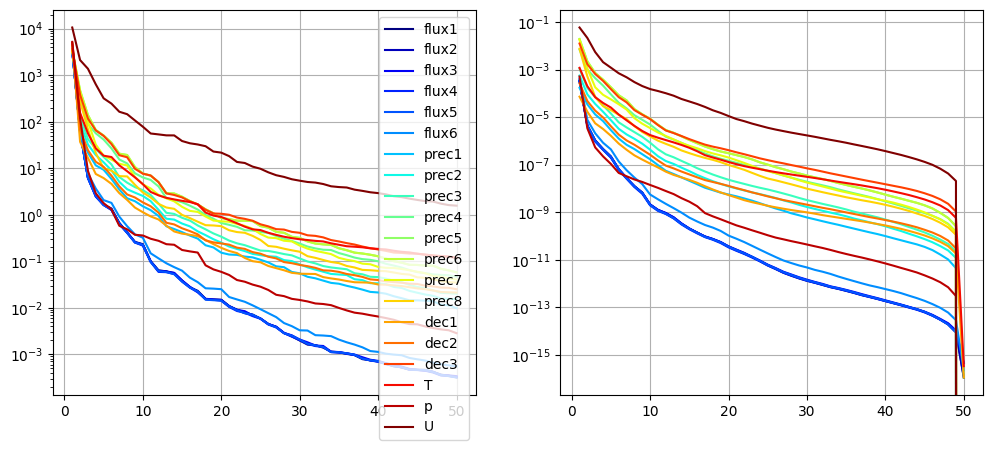

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot, 1-np.cumsum(s_total[field]**2) / np.sum(s_total[field]**2), color=colors[field_i], label=field)
axs[0].grid()
axs[1].grid()
axs[0].legend()

In [22]:
from scipy.interpolate import CubicSpline
from pyforce.tools.write_read import StoreFunctionsList
import os

if compress_data:
    path='./CompressedDataset/'
    if not os.path.exists(path):
        os.makedirs(path)
        
    pickle.dump(u_total, open(path+"u_total.svd", 'wb'))
    pickle.dump(v_total, open(path+"v_total.svd", 'wb'))
    pickle.dump(s_total, open(path+"s_total.svd", 'wb'))
    pickle.dump(new_var_names, open(path+"var.names", 'wb'))

    pickle.dump(rescaling_snaps, open(path+"rescaling.svd", 'wb'))
    pickle.dump(Nmodes, open(path+"Nmodes.svd", 'wb'))

else:
    path='./OfflineSVD/'
    if not os.path.exists(path):
        os.makedirs(path)
        
    [r,nt] = v_total.shape
    t = np.asarray(times)
    newnt = 2000

    new_t = np.linspace(t[0], t[-1], newnt)
    v_total_new = np.zeros((r,newnt))

    for j in range(r):
        spline = CubicSpline(t, v_total[j,:])
        v_total_new[j,:] = spline(new_t)

    pickle.dump(u_total, open(path+"u_total.svd", 'wb'))
    pickle.dump(v_total_new, open(path+"v_total.svd", 'wb'))
    pickle.dump(s_total, open(path+"s_total.svd", 'wb'))
    pickle.dump(new_var_names, open(path+"var.names", 'wb'))

    pickle.dump(rescaling_snaps, open(path+"rescaling.svd", 'wb'))
    pickle.dump(Nmodes, open(path+"Nmodes.svd", 'wb'))

In [8]:
# import matplotlib.pyplot as plt

# plt.plot(new_t, v_total_new[30:35].T)
# plt.plot(times, v_total[30:35].T, '--')